**Nhóm 13**
-----------
**Sinh viên thực hiện:**
- Nguyễn Tiến Toàn -- 19120399
- Nguyễn Trung Dũng -- 19120486

**Phân công công việc:**
- Nguyễn Tiến Toàn: viết code thực thi cho device version 1, 2 và 3, viết báo cáo và đo thời gian chạy.
- Nguyễn Trung Dũng: viết code thực thi cho host, device version 1, 2, 3, 4, và 2 version thử nghiệm.

In [1]:
import gdown
gdown.download_folder("https://drive.google.com/drive/folders/1-Im7pVee6SvY3MpgEV5w2I5BNozz4RX7", quiet=True)

['/content/test pnms/lotr.pnm',
 '/content/test pnms/solaire.pnm',
 '/content/test pnms/stress_test.pnm',
 '/content/test pnms/test1.pnm',
 '/content/test pnms/test2.pnm',
 '/content/test pnms/tower.pnm']

In [2]:
import cv2
import matplotlib.pyplot as plt

def show_2images(filename, width, host=True):
    img1 = cv2.imread(f"{filename}.pnm")
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)

    suffix = f"{width}_host.pnm" if host else "_device.pnm"
    img2 = cv2.imread(f"{filename}{suffix}")
    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(24, 16))
    ax1 = plt.subplot(2,1,1)
    ax2 = plt.subplot(2,1,2)
    axes = [ax1, ax2]

    axes[0].imshow(img1)
    axes[1].imshow(img2)

def show_3images(filename, width):
    img1 = cv2.imread(f"{filename}.pnm")
    img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)

    img2 = cv2.imread(f"{filename}{width}_host.pnm")
    img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

    img3 = cv2.imread(f"{filename}{width}_device.pnm")
    img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(24, 16))
    ax1 = plt.subplot(2,1,1)
    ax2 = plt.subplot(2,2,3)
    ax3 = plt.subplot(2,2,4)
    axes = [ax1, ax2, ax3]

    axes[0].imshow(img1)
    axes[1].imshow(img2)
    axes[2].imshow(img3)

In [3]:
import filecmp
def check_correctness(correct_file, to_check):
    if filecmp.cmp(correct_file, to_check):
        print("CORRECT, SAME AS HOST :)")
    else:
        print("INCORRECT :(")

In [4]:
from numba import cuda
major, minor = cuda.get_current_device().compute_capability
print(f'GPU compute capability: {major}.{minor}')

GPU compute capability: 7.5


**1. Mô tả ứng dụng**
=====================

**Ứng dụng:** Thay đổi kích thước ảnh bằng phương pháp "seam carving"
- Mô tả: Seam carving là một kỹ thuật thay đổi kích thước ảnh mà không làm biến dạng các đối tượng quan trọng trong ảnh đó, còn gọi là content-aware scaling.
- Input: một tấm ảnh kích thước $w \times h$.
- Output: ảnh đã được phóng to / thu nhỏ với kích thước $w' \times h'$. Trong đồ án này, chỉ có $w$ sẽ thay đổi (thu hẹp).
- Ý nghĩa thực tế của ứng dụng: một use case là ta có thể muốn có các phiên bản với các kích thước khác nhau của cùng một tấm ảnh để hiển thị trên các thiết bị khác nhau (máy tính, điện thoại, ...) mà không làm biến dạng hay mất đi các đối tượng quan trọng so với các phương pháp scaling/cropping truyền thống.
- Thuật toán truyền thống cài trên CPU có một số điểm có thể song song hóa để chạy trên GPU, rút ngắn thời gian đáng kể.

**2. Cài đặt tuần tự**
======================
**Thiết kế:** tổng quan các bước
- B1: Tính độ quan trọng ($energy$) của các điểm ảnh trong hình ($w \times h)$ dùng edge detection convolution trên 2 filter Sobel cho 2 trục $x$ và $y$.
- B2: Tính mảng lưu độ quan trọng tích lũy dùng phương pháp quy hoạch động đi từ dòng đầu tiên tới dòng cuối cùng với công thức:
$$
    dp[r, c] = \min_{c-1 \leq k \leq c+1}\{dp[r-1, k]\} + energy[r, c]
$$

- B3: Giá trị nhỏ nhất trên hàng cuối cùng sẽ là tổng tích lũy nhỏ nhất của 1 seam nào đó (seam ít energy nhất, cần xóa). Duyệt các phần tử trên hàng cuối cùng và tìm index của giá trị này.
- B4: Từ index này, truy vết ngược về hàng đầu tiên để lấy ra danh sách các điểm ảnh của seam cần xóa.
- B5: Cập nhật lại ảnh bằng cách ghi đè mảng input và cập nhật $w \leftarrow w - 1$.
- B6: Lặp lại từ bước 1 cho tới khi $w = w'$

**Đánh giá:**
- Kịch bản thí nghiệm: thuật toán sẽ được chạy trên ảnh với kích thước là $3840 \times 1583$; với các $w'$ lần lượt là $3000$, $1920$, và $10$
- Thời gian chạy (trung bình 10 lần chạy):
    - $w' = 3000$: <font color='#99ff00'>16949.89844 ms</font>
    - $w' = 1920$: <font color='#99ff00'>32208.47536 ms</font>
    - $w' = 10$: <font color='#99ff00'>42947.519531 ms</font>

In [5]:
!make host CC={major}{minor}

nvcc -arch=sm_75 -c utils.cu -o utils.o
nvcc -arch=sm_75 -O2 -c sc-host.cu -o sc-host.o
nvcc -arch=sm_75 -DDONT_RUN_ON_DEVICE -c -I. main.cu -o main_host.o
nvcc -arch=sm_75 main_host.o utils.o sc-host.o -o seam-carving_host


In [6]:
!./seam-carving_host stress_test.pnm 3000


Image size (width x height): 3840 x 1583
Processing time (use host): 21529.097656 ms



In [7]:
!./seam-carving_host stress_test.pnm 1920


Image size (width x height): 3840 x 1583
Processing time (use host): 36949.292969 ms



In [8]:
!./seam-carving_host stress_test.pnm 10


Image size (width x height): 3840 x 1583
Processing time (use host): 44487.648438 ms



#### Ảnh với $w' = 1920$ (gốc và host)

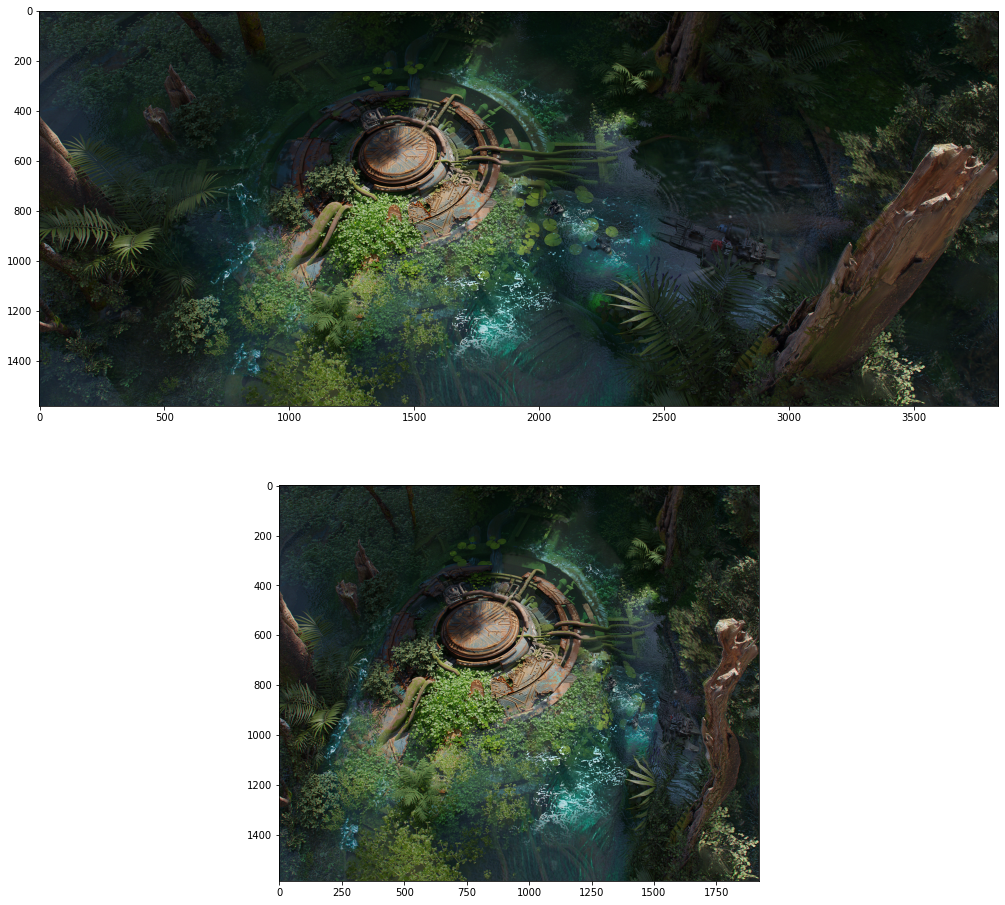

In [9]:
show_2images("stress_test", width=1920, host=True)

<hr>

**3. Cài đặt song song**
========================
**Phân tích:**\
Nhóm nhận thấy có một số bước tính toán có thể song song hóa được:
- Tính độ quan trọng bằng phương pháp convolution dùng edge detection (tính toán trên các điểm ảnh với convolution thì các điểm ảnh trong mảng energy không phụ thuộc vào nhau nên có thể được tính song song độc lập với nhau.
- Trong bước tính độ quan trọng tích lũy, các điểm ảnh trên cùng một hàng có thể được tính độc lập với nhau; như vậy thì các hàng sẽ được tính tuần tự, mỗi hàng thì được tính song song.
- Tìm index trên hàng cuối cùng thì có thể song song hóa bằng cách dùng thuật toán reduction trên GPU.
- Bước cập nhật ảnh cũng có thể song song hóa được vì các điểm ảnh trên cùng 1 hàng trong mảng không phụ thuộc với nhau nên có thể được cập nhật cùng 1 lúc. Nhưng vì tác vụ ghi đè dồn các phần tử lên phía trước có tính tuần tự cao nên các hàng sẽ được thực thi tuần tự.

**Thiết kế:**
- Bước cài đặt khá giống với cài đặt trên host.
    - Tính độ quan trọng thì dùng 1 kernel với grid 2D và block 2D; mỗi điểm ảnh sẽ được tính bởi 1 thread.
    - Tính tổng tích lũy độ quan trọng thì dùng 1 kernel chạy trên 1 block 1D, chạy 1 vòng lặp tính các hàng một cách tuần tự.
    - Tìm index trên hàng cuối thì chạy 1 kernel reduction trên hàng cuối của mảng tổng tích lũy để lưu kết quả của mỗi block, sau đó chạy lại trên host để lấy giá trị cuối cùng.
    - Cập nhật lại ảnh bằng cách chạy 1 kernel trên 1 block 1D, chạy 1 vòng lặp tính các hàng.

**Đánh giá:**
- Kịch bản thí nghiệm: tương tự như host
- Thời gian chạy (trung bình 10 lần chạy):
    - $w' = 3000$: <font color='#99ff00'>14042.202148 ms</font>
    - $w' = 1920$: <font color='#99ff00'>27738.544922 ms</font>
    - $w' = 10$: <font color='#99ff00'>37767.964844 ms</font>

In [10]:
!make device VER=1 CC={major}{minor}

nvcc -arch=sm_75 -Xptxas -O3 -Xcompiler -O2 -c -I. ./ver_1/sc-device.cu -o ./ver_1/sc-device_v1.o
nvcc -arch=sm_75 -DDONT_RUN_ON_HOST -c -I. -I./ver_1 main.cu -o main_device_v1.o
nvcc -arch=sm_75 main_device_v1.o utils.o ./ver_1/sc-device_v1.o -o seam-carving_device_v1


In [11]:
!./seam-carving_device_v1 stress_test.pnm 3000
check_correctness("stress_test3000_host.pnm", "stress_test3000_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 14656.619141 ms

CORRECT, SAME AS HOST :)


In [12]:
!./seam-carving_device_v1 stress_test.pnm 1920
check_correctness("stress_test1920_host.pnm", "stress_test1920_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 29269.607422 ms

CORRECT, SAME AS HOST :)


In [13]:
!./seam-carving_device_v1 stress_test.pnm 10
check_correctness("stress_test10_host.pnm", "stress_test10_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 39778.851562 ms

CORRECT, SAME AS HOST :)


<hr>

**4. Cài đặt song song + tối ưu hóa**
=====================================

**4.1 Version 2 (baseline: version 1)**
-----------------
**Phân tích:**
- Nhận thấy rằng việc ghi đè lên mảng input để xóa seam có tính tuần tự cao nên hàm kernel cập nhật input của version 1 chưa được song song hóa một cách hoàn toàn nhất.</br>
$\Rightarrow$ Thay vì cập nhật bằng cách ghi đè thì ta có thể lưu input dưới 2 mảng thay phiên nhau để việc cập nhật có thể được song song hóa hoàn toàn.

**Thiết kế:**
- Hàm cập nhật (`carveSeamKernel()`) sẽ được chạy trên grid 2D và block 2D.
- Cuối mỗi vòng lặp sau khi bỏ seam thì swap pointer của 2 mảng input với nhau.

**Đánh giá:**
- Kịch bản thí nghiệm: tương tự như host
- Thời gian chạy (trung bình 10 lần chạy):
    - $w' = 3000$: <font color='#99ff00'>10672.167969 ms</font>
    - $w' = 1920$: <font color='#99ff00'>21671.195312 ms</font>
    - $w' = 10$: <font color='#99ff00'>28579.359375 ms</font>

In [14]:
!make device VER=2 CC={major}{minor}

nvcc -arch=sm_75 -Xptxas -O3 -Xcompiler -O2 -c -I. ./ver_2/sc-device.cu -o ./ver_2/sc-device_v2.o
nvcc -arch=sm_75 -DDONT_RUN_ON_HOST -c -I. -I./ver_2 main.cu -o main_device_v2.o
nvcc -arch=sm_75 main_device_v2.o utils.o ./ver_2/sc-device_v2.o -o seam-carving_device_v2


In [15]:
!./seam-carving_device_v2 stress_test.pnm 3000
check_correctness("stress_test3000_host.pnm", "stress_test3000_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 11370.305664 ms

CORRECT, SAME AS HOST :)


In [16]:
!./seam-carving_device_v2 stress_test.pnm 1920
check_correctness("stress_test1920_host.pnm", "stress_test1920_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 22548.189453 ms

CORRECT, SAME AS HOST :)


In [17]:
!./seam-carving_device_v2 stress_test.pnm 10
check_correctness("stress_test10_host.pnm", "stress_test10_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 30357.486328 ms

CORRECT, SAME AS HOST :)


<hr>

**4.2 Version 3 (baseline: version 2)**
-----------------
**Phân tích:**
- Giai đoạn truy vết được chạy trên host. Như vậy host cần phải lấy được giá trị truy vết mà device đã tính được từ việc tính tổng tích lũy độ quan trọng.
- Sau khi tính tổng tích lũy thì cũng cần phải chạy reduction trên hàng cuối cùng của mảng đó.</br>
$\Rightarrow$ Thấy rằng việc tính reduction và copy dữ liệu tổng tích lũy từ device sang host có overlap với nhau.

**Thiết kế:**
- Chia 2 stream khác null, 1 stream để chạy reduction (`minReductionKernel()`), 1 stream để copy dữ liệu mảng tích lũy từ device sang host.

**Đánh giá:**
- Kịch bản thí nghiệm: tương tự như host
- Thời gian chạy (trung bình 10 lần chạy):
    - $w' = 3000$: <font color='#99ff00'>6782.556889 ms</font>
    - $w' = 1920$: <font color='#99ff00'>13600.155273 ms</font>
    - $w' = 10$: <font color='#99ff00'>18488.808594 ms</font>

In [18]:
!make device VER=3 CC={major}{minor}

nvcc -arch=sm_75 -Xptxas -O3 -Xcompiler -O2 -c -I. ./ver_3/sc-device.cu -o ./ver_3/sc-device_v3.o
nvcc -arch=sm_75 -DDONT_RUN_ON_HOST -c -I. -I./ver_3 main.cu -o main_device_v3.o
nvcc -arch=sm_75 main_device_v3.o utils.o ./ver_3/sc-device_v3.o -o seam-carving_device_v3


In [19]:
!./seam-carving_device_v3 stress_test.pnm 3000
check_correctness("stress_test3000_host.pnm", "stress_test3000_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 6498.120117 ms

CORRECT, SAME AS HOST :)


In [20]:
!./seam-carving_device_v3 stress_test.pnm 1920
check_correctness("stress_test1920_host.pnm", "stress_test1920_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 12465.321289 ms

CORRECT, SAME AS HOST :)


In [21]:
!./seam-carving_device_v3 stress_test.pnm 10
check_correctness("stress_test10_host.pnm", "stress_test10_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 17649.390625 ms

CORRECT, SAME AS HOST :)


<hr>

**4.3 Version 4 (baseline: version 3)**
-----------------
**Phân tích:**
- Để ý từ version 1 &rarr; 3, kernel tính tổng tích lũy độ quan trọng chỉ được thực thi trên 1 block duy nhất, không tận dụng tối đa tài nguyên của GPU.
- Version 4 sẽ thực thi kernel này trên nhiều hơn 1 block (tuy nhiên việc tính tổng tích lũy có tính tuần tự nên các block có thể phải đợi nhau để thực thi).

**Thiết kế:**
- Hàm tính tổng tích lũy (`computeSeamsKernel()`) được sửa đổi để có thể chạy trên nhiều block.
- Vì hàng dưới phụ thuộc hàng trên khi tính tổng nên một số block khi xuống hàng tiếp theo thì sẽ đợi các block bên cạnh thực hiện xong việc tính hàng trên để lấy kết quả.
- Ngoài ra số lượng block chạy (gridSize) cũng được giới hạn lại cho phù hợp để không có block nào phải vào hàng đợi trong SM $\Rightarrow$ tránh hiện tượng deadlock vì các block phụ thuộc vào kết quả của 2 block bên cạnh.

**Đánh giá:**
- Kịch bản thí nghiệm: tương tự như host
- Thời gian chạy (trung bình 10 lần chạy):
    - $w' = 3000$: <font color='#99ff00'>5396.897461 ms</font>
    - $w' = 1920$: <font color='#99ff00'>10708.653320 ms</font>
    - $w' = 10$: <font color='#99ff00'>16388.464844 ms</font>

In [22]:
!make device VER=4 CC={major}{minor}

nvcc -arch=sm_75 -Xptxas -O3 -Xcompiler -O2 -c -I. ./ver_4/sc-device.cu -o ./ver_4/sc-device_v4.o
nvcc -arch=sm_75 -DDONT_RUN_ON_HOST -c -I. -I./ver_4 main.cu -o main_device_v4.o
nvcc -arch=sm_75 main_device_v4.o utils.o ./ver_4/sc-device_v4.o -o seam-carving_device_v4


In [23]:
!./seam-carving_device_v4 stress_test.pnm 3000
check_correctness("stress_test3000_host.pnm", "stress_test3000_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 5019.202637 ms

CORRECT, SAME AS HOST :)


In [24]:
!./seam-carving_device_v4 stress_test.pnm 1920
check_correctness("stress_test1920_host.pnm", "stress_test1920_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 10034.533203 ms

CORRECT, SAME AS HOST :)


In [25]:
!./seam-carving_device_v4 stress_test.pnm 10
check_correctness("stress_test10_host.pnm", "stress_test10_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 15356.609375 ms

CORRECT, SAME AS HOST :)


<hr>

**4.4 Version thử nghiệm mutex (baseline: version 3)**
-----------------
**Phân tích:**
- Trong hàm kernel reduction, thay vì lưu xuống 1 mảng chứa kết quả cho các block thì ta có thể lưu trực tiếp vào một biến trong global memory.

**Thiết kế:**
- Hàm reduction (`minReductionKernel()`) được sửa đổi để lưu kết quả mỗi block xuống 1 phần tử duy nhất trong global memory.
- Vì nhiều thread truy cập vào cùng 1 địa chỉ bộ nhớ nên có thể gây ra race condition.\
$\Rightarrow$ Sử dụng mutex để giới hạn quyền truy cập bộ nhớ cho duy nhất thread trong cùng một lúc.

**Đánh giá:**
- Kịch bản thí nghiệm: tương tự như host
- Thời gian chạy (trung bình 10 lần chạy):
    - $w' = 3000$: <font color='#99ff00'>7023.774335 ms</font>
    - $w' = 1920$: <font color='#99ff00'>13403.022461 ms</font>
    - $w' = 10$: <font color='#99ff00'>18458.414062 ms</font>
- Có thể thấy thời gian chạy của version 3 dùng mutex không có cải tiến gì lớn. Lý do có thể là số lượng phần tử ít nên số lượng block cũng ít, và CPU cũng đủ nhanh để chạy vòng lặp trên mảng kết quả của block rồi.

In [26]:
!make device VER=3_mutex CC={major}{minor}

nvcc -arch=sm_75 -Xptxas -O3 -Xcompiler -O2 -c -I. ./ver_3_mutex/sc-device.cu -o ./ver_3_mutex/sc-device_v3_mutex.o
nvcc -arch=sm_75 -DDONT_RUN_ON_HOST -c -I. -I./ver_3_mutex main.cu -o main_device_v3_mutex.o
nvcc -arch=sm_75 main_device_v3_mutex.o utils.o ./ver_3_mutex/sc-device_v3_mutex.o -o seam-carving_device_v3_mutex


In [27]:
!./seam-carving_device_v3_mutex stress_test.pnm 3000
check_correctness("stress_test3000_host.pnm", "stress_test3000_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 6381.219238 ms

CORRECT, SAME AS HOST :)


In [28]:
!./seam-carving_device_v3_mutex stress_test.pnm 1920
check_correctness("stress_test1920_host.pnm", "stress_test1920_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 12794.731445 ms

CORRECT, SAME AS HOST :)


In [29]:
!./seam-carving_device_v3_mutex stress_test.pnm 10
check_correctness("stress_test10_host.pnm", "stress_test10_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 18270.796875 ms

CORRECT, SAME AS HOST :)


<hr>

**4.5 Version thử nghiệm skip (baseline: version 3)**
-----------------
**Phân tích:**
- Thấy khi tính độ quan trọng dùng convolution (edge detection), các điểm ảnh nằm xa seam vừa bị xóa không bị ảnh hưởng.
- Có thể bỏ qua tính các điểm ảnh này và chỉ tính lại độ quan trọng cho các điểm ảnh là neighbor của seam vừa bị xóa (host được code theo cách này)

**Thiết kế:**
- Thêm 1 hàm tính energy (`computeEnergySkip()`) cho các lần chạy sau, tương tự như hàm tính energy gốc (`computeEnergy()`) nhưng chỉ tính lại các điểm ảnh lân cận seam vừa bị xóa.

**Đánh giá:**
- Kịch bản thí nghiệm: tương tự như host
- Thời gian chạy (trung bình 10 lần chạy):
    - $w' = 3000$: <font color='#99ff00'>7220.914062 ms</font>
    - $w' = 1920$: <font color='#99ff00'>13694.226562 ms</font>
    - $w' = 10$: <font color='#99ff00'>17005.029297 ms</font>
- Có thể thấy thời gian chạy của version 3 dùng phương pháp trên cũng không có cải tiến gì. Vì các điểm ảnh được tính song song khá nhanh trong hàm tính energy gốc rồi nên phiên bản này không làm giảm thời gian chạy trung bình.

In [30]:
!make device VER=3_skip CC={major}{minor}

nvcc -arch=sm_75 -Xptxas -O3 -Xcompiler -O2 -c -I. ./ver_3_skip/sc-device.cu -o ./ver_3_skip/sc-device_v3_skip.o
nvcc -arch=sm_75 -DDONT_RUN_ON_HOST -c -I. -I./ver_3_skip main.cu -o main_device_v3_skip.o
nvcc -arch=sm_75 main_device_v3_skip.o utils.o ./ver_3_skip/sc-device_v3_skip.o -o seam-carving_device_v3_skip


In [31]:
!./seam-carving_device_v3_skip stress_test.pnm 3000
check_correctness("stress_test3000_host.pnm", "stress_test3000_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 6616.064941 ms

CORRECT, SAME AS HOST :)


In [32]:
!./seam-carving_device_v3_skip stress_test.pnm 1920
check_correctness("stress_test1920_host.pnm", "stress_test1920_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 12996.316406 ms

CORRECT, SAME AS HOST :)


In [34]:
!./seam-carving_device_v3_skip stress_test.pnm 10
check_correctness("stress_test10_host.pnm", "stress_test10_device.pnm")

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 3840 x 1583
Processing time (use device): 17207.429688 ms

CORRECT, SAME AS HOST :)


**5. Nhìn lại**
===============
Nhóm đã học được nhiều kĩ thuật tối ưu hóa cho chương trình chạy song song trên GPU.\
Nếu có thêm thời gian thì có thể cải tiến chương trình hơn nữa, sử dụng các phương pháp khác để tính energy (dùng gradient, dùng convolution phức tạp hơn) để áp dụng biến đổi Fourier; chỉnh sửa thuật toán quy hoạch động để có thể song song hóa tính toán nhiều hàng với nhau (overhead khá lớn)